# **Digital Signal and Image Management - Assignement 2**<br/>

**Master's Degree in Data Science (A.Y. 2024/2025)**<br/>
**University of Milano - Bicocca**<br/>

Student: Sara **Nava**, mat. **870885**

## **Assignement Description**

Implement two distinct feature extractors based respectively on **Spectrogram**, and **MFCC**. Consider a single-channel audio signal, and start from the commands shown during the laboratory.

**Rules**:

- Show the effects on classification performance for the dataset "free-spoken-digit-dataset" (recordings.tar).
- No feature combination is required for this assignment.
- You can (and should!) use Librosa for the audio description.


**Approach**:
1. Extract the 2-dimensional feature
2. Force the feature to have fixed size
3. Unroll the 2-dimensional feature into a 1-dimensional vector

**Hint:**
* For a given feature (e.g. Spectrogram) we still want to **fix the feature length**, independent of the initial audio track.
* Since now we have two dimensions (rows = frequencies, and cols = time blocks), we have to think about both.
  * The **rows** will be **fixed by default**, assuming fixed parameters for the spectrogram extraction.
  * The **columns will change**, based on the duration of the input track.
* Fixing the feature size *after* unrolling to 1 dimension would be easier, but it is conceptually wrong:
  * Unrolling two matrices with different columns would distribute the same frequencies in different positions in the vector.
  * This would make the classifier unable to reliably "look" for a specific sub-feature in a specific position.

## **Import packages**
Import main packages

In [1]:
# Import
import os
import numpy as np
from time import time
from scipy.io import wavfile as wav
import matplotlib.pyplot as plt
import IPython.display as ipd
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from google.colab import drive
import tarfile
from shutil import copyfile

from scipy.fft import fft, fftfreq, rfft, rfftfreq
from scipy.signal import spectrogram
from librosa.feature import melspectrogram, mfcc
from librosa.display import specshow
from sklearn.preprocessing import scale

## **Load Data**
Data can be retrieved from Google Drive, as follows:

In [2]:
# Define directory path
my_dir = 'gdrive/My Drive/Digital Signal and Image Management'

In [3]:
# Link Google Drive account
drive.mount('/content/gdrive')
copyfile(f'{my_dir}/recordings.tar', 'recordings.tar')
tar = tarfile.open('recordings.tar')
tar.extractall()
tar.close()

Mounted at /content/gdrive


Then, define the function `load_data` that allows to load the data and split it into training and test sets.

In [4]:
# Placecholder for feature extractor
def identity(input):
    return input

# Data loader
def load_data(feature_extractor=identity, normalize=False):

    labels = []
    features = []

    for f in sorted(os.listdir('./recordings')):
        if f.endswith('.wav'):
            # Load file and compute the requested features
            _, signal = wav.read('./recordings/' + f)
            cur_features = feature_extractor(signal)
            features.append(cur_features)

            # Classes
            label = f.split('_')[0]
            labels.append(label)

    # X: features, y: labels
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.1, random_state=1)

    if normalize:
        eps = 0.001
        X_train = np.array(X_train)
        X_train_mean = X_train.mean(axis=0)
        X_train_std = X_train.std(axis=0)
        X_train = (X_train - X_train_mean + eps)/(X_train_std + eps)
        X_train = [row for row in X_train]

        X_test = [row for row in (np.array(X_test) - X_train_mean + eps)/(X_train_std + eps)]

    return X_train, X_test, y_train, y_test

The function is structured as follows:
1. **Load** the **data** from gdrive (gdrive repository already mounted)
2. **Extract** the **class** specified in the filename
3. **Split** audio tracks into **training** and **test set**
4. **Normalize** the **data** using training set statistics (if the normalize statement is set to `True`)

## **Assignement 2.a: Temporal/Frequency features (spectrogram)**

As in the first assignment, an initial approach involves **testing the function** on a **single audio track**. This allows for establishing a baseline and verifying functionality before applying it to a larger dataset.

### **1. Extract the 2-dimensional feature**
To implement a feature extractor based on **Spectrogram**, apply the function `spectrogram`. It computes a spectrogram with consecutive Fourier transforms (legacy function).

**Spectrograms** can be used as a way of visualizing the change of a non-stationary signal’s frequency content over time ([references](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.spectrogram.html)).

In [5]:
# Assign a signle audio track to a variable
sound_rate, sound_data = wav.read('recordings/0_jackson_0.wav')

Now, apply the `spectrogram` function to this audio track.

In [6]:
[spec_freqs, spec_times, spec] = spectrogram(sound_data, fs=sound_rate)

The output is:

    f
    ndarray: Array of sample frequencies.
    t
    ndarray: Array of segment times.
    Sxx
    ndarray: Spectrogram of x. By default, the last axis of Sxx corresponds to the segment times.

Note that the `Sxx` dimensions correspond to the shapes of `f` and `t`, respectively. Let's check it out:

In [7]:
# f shape, t shape, Sxx shape
spec_freqs.shape, spec_times.shape, spec.shape

((129,), (22,), (129, 22))

Since a two-dimensional feature is required, the `spec` matrix should be used to **build the feature extractor**.

### **2. Force the feature to have fixed size**
As specified in the assignment, it is necessary to implement code that **enforces a fixed size for the temporal dimension** (columns of the `spec` matrix) while working with 2-dimensional data, rather than flattening the dimensions into one before applying the enforcement procedures.

In [8]:
time_size = 10
truncated_matrix = spec[:, 0:min(spec.shape[1], time_size)]
if truncated_matrix.shape[1] < time_size:
  zero_padding = np.zeros((truncated_matrix.shape[0], time_size - truncated_matrix.shape[1]))
  output_matrix = np.concatenate((truncated_matrix, zero_padding), axis=1)
else:
  output_matrix = truncated_matrix

output_matrix.shape

(129, 10)

**How does it work?**

1.	Set a **fixed time size** (e.g., 10).
2.	Create a **truncated matrix** by selecting the number of columns, that is the minimum value between the column count of the original matrix and the specified time size.
3.	**Check** if the **number of columns** in the truncated matrix is **less than the fixed time size**. If the truncated matrix has fewer columns:
  - Create a **zero-padding** matrix with the necessary dimensions.
  - **Concatenate** the truncated matrix with the zero-padding matrix to form the output matrix.
4.	Instead, if the truncated matrix has enough columns:
  - Assign the truncated matrix directly to the output matrix.
5.	Return the shape of the output matrix.

It can be verified that the dimensions of `spec` matrix have been reduced from (129, 22) to (129, 10).

### **3. Unroll the 2-dimensional feature into a 1-dimensional vector**
Now, **unroll** the 2-dimensional `output_matrix` into a 1-dimensional vector.

To meet this requirement, the `ravel` function may be useful ([references](https://numpy.org/doc/2.1/reference/generated/numpy.ravel.html)).

In [9]:
output_feature = output_matrix.ravel()
output_feature.shape, output_matrix.shape

((1290,), (129, 10))

It can be observed that the unrolling works correctly, as the array’s length matches the product of the matrix rows (129) and columns (10).

### **4. Implement the feature extractor**

A function can now be defined to assemble all the **previous steps** to be **applied to the entire dataset**. Default parameters are specified, such as `rate` (e.g., when applying the spectrogram to audio data, the sample rate is set to $8000$), that is the number of samples per second in the signal, and `tsize` (set to $10$), which determines the number of temporal blocks, enabling truncation or padding to achieve a fixed size.

In [10]:
def feats_spectrogram(input, rate=8000, tsize=10):
    # Step 1: Extract 2-dimensional feature through the function spectrogram
    [spec_freqs, spec_times, spec] = spectrogram(input, fs=rate)

    # The input matrix is `spec`
    input_matrix = spec

    # Step 2: Force the feature time (columns of spec) to have a fixed size
    truncated_matrix = input_matrix[:, 0:min(input_matrix.shape[1], tsize)]
    if truncated_matrix.shape[1] < tsize:
      zero_padding = np.zeros((truncated_matrix.shape[0], tsize - truncated_matrix.shape[1]))
      output_matrix = np.concatenate((truncated_matrix, zero_padding), axis=1)
    else:
      output_matrix = truncated_matrix

    # Step 3: Unroll the 2-dimensional feature into a 1-dimensional vector
    output = output_matrix.ravel()

    return output

### **5. Spectrogram Feature Extractor Application**
Assess the effects of the implemented feature extractor on classification performance for the dataset *free-spoken-digit-dataset*.



In [11]:
# Data loading
X_train, X_test, y_train, y_test = load_data(feature_extractor=feats_spectrogram, normalize=True)

Define **SVM classificator** with hyperparameters optimization:

In [12]:
# Parameters to be tested in cross-validation
param_grid = {'C': [100, 500, 1000],
          'gamma': [0.005, 0.01, 0.1, 0.5, 1.0]}

# Support Vector Machine initialization
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=2)

# Training
t0 = time()
clf = clf.fit(X_train, y_train)
print('Training completed in %0.3fs' % (time() - t0))

Training completed in 27.555s


Print a summary of cross validation for the parameters selection:

In [13]:
# Result of the cross validation for parameters selection
print('Best parameters combination:')
print(' C: '+str(clf.best_estimator_.C))
print(' gamma: '+str(clf.best_estimator_.gamma))

Best parameters combination:
 C: 1000
 gamma: 0.005


Finally, make predictions on the test set and comment on the classification performance and confusion matrix.

**Classification Metrics**

- **Precision**: Precision measures how many of the positive predictions made by the model are actually correct. High precision indicates a low rate of false positives.
$$\frac{True Positives}{(True Positives + False Positives)}$$

- **Recall**: Recall measures how many of the actual positive instances are correctly identified by the model. High recall means most positives are detected.
$$\frac{True Positives}{(True Positives + False Negatives)}$$

- **F1-Score**: The F1-score is the harmonic mean of precision and recall, balancing both metrics. It’s especially useful when the classes are imbalanced, as it considers both precision and recall in a single metric.
$$\frac{2 * (Precision * Recall) }{(Precision + Recall)}$$

- **Accuracy**: Accuracy represents the overall proportion of correctly classified instances (both positives and negatives) out of all instances. However, accuracy alone can be misleading in cases of imbalanced classes.
$$\frac{(True Positives + True Negatives)}{Total Instances}$$

In [14]:
# SVM test
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.59      0.69        17
           1       0.58      0.70      0.64        10
           2       0.77      0.67      0.71        15
           3       0.65      0.58      0.61        19
           4       0.30      0.27      0.29        11
           5       0.75      0.64      0.69        14
           6       0.18      0.64      0.28        14
           7       0.67      0.32      0.43        19
           8       0.80      0.24      0.36        17
           9       0.67      0.43      0.52        14

    accuracy                           0.50       150
   macro avg       0.62      0.51      0.52       150
weighted avg       0.64      0.50      0.53       150



The results show that, in most cases, the **classifier’s precision is higher than its recall**. This indicates that while the model performs relatively well in identifying positives among its predictions, it tends to miss many true positives, leading to lower recall. Specifically, the model’s positive predictions have a higher proportion of correct classifications, but it struggles to capture all actual positive cases in the dataset.

However, there are exceptions. For classes 6 and 1, recall is notably higher than precision, suggesting that for these classes, the model identifies more of the actual positives but also includes a larger number of false positives. Conversely, classes 0, 7, 8, and 9 show a clear trend where precision outperforms recall, highlighting the classifier’s strength in avoiding false positives for these classes, even if it misses some true positives.

Notably, while class 8 demonstrates one of the highest precision scores (80%), it also has the lowest recall (24%).

**Average Performance**: Precision across all classes averages around 60%, while recall lags at around 50%. This overall pattern supports the observation that the model is conservative in making positive predictions, often favoring precision over recall. However, these indices stand around low values.

**Class-by-Class F1-Score**: The F1-scores summarize the classifier's limited performance, balancing precision and recall. The highest scores are observed for classes 0, 2, and 5 (around 70%), while the lowest are those of classes 4, 6 and 8 (around 30%). The others fall in the 40%-60% range, highlighting that the classifier's performance remains suboptimal.

**Overall Accuracy**: The overall accuracy of around 50% suggests that the classifier is effectively making predictions akin to random guessing in many cases, with significant room for improvement.

Confusion matrix:


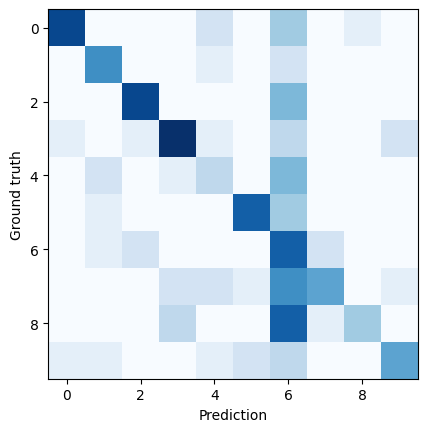

In [15]:
# Confusion matrix
print('Confusion matrix:')
cm = confusion_matrix(y_test, y_pred)
plt.imshow(cm, cmap=plt.cm.Blues);
plt.xlabel('Prediction');
plt.ylabel('Ground truth');

The confusion matrix provides insight into how classifications are distributed across classes, further illustrating trends seen in the precision and recall metrics. To interpret the matrix, observe rows and columns: **rows reflect actual classes** and **columns reflect the predicted ones**.

For example, in **class 8**, reading across its row reveals that very few observations were correctly classified as 8 (indicated by the lighter square on the diagonal), while many were **misclassified as classes 3, 7, and particularly 6**. This **confirms the low recall for class 8**, as many true instances are missed. Reading down the column for class 8 shows that few observations were predicted as class 8, but most of those predictions are correct, leading to **high precision**. Based on this observation, the intersection of a row with other columns can be interpreted as the recall for the row-class, while, conversely, the intersection of a column with other rows represents the precision for the column-class.

One notable pattern is that across multiple classes, a **significant proportion of observations is misclassified as class 6**, contributing to its low precision. This happens because a large number of instances from other classes are incorrectly assigned to class 6, leading to a high denominator and thus a low precision score. Specifically, classes 4 and 8 frequently end up misclassified as class 6 rather than their true labels.

Additionally, the matrix reveals a **clear class imbalance**: some classes have far fewer observations, indicated by the varying intensity of colors along the diagonal. For instance, classes 1 and 4 have significantly fewer samples than class 3. This imbalance likely contributes to the classifier’s inconsistent performance. The imbalance and uneven distribution of classifications suggest that the classifier’s performance is somewhat arbitrary and unstable across classes.

## **Assignement 2.b: Cepstral features (MFCC)**

To implement a feature extractor based on **MFCC** (*Mel-Frequency Cepstral Coefficients*), it can be useful to follow the previous approach: first, define and test the procedure on a single audio signal, then create a function to apply it across the entire dataset and assess the effects of the implemented feature extractor on classification performance for the dataset "free-spoken-digit-dataset".

### **1. Extract the 2-dimensional feature**

To extract 2-dimensional feature, it is necessary to apply the `mfcc` function ([references](https://librosa.org/doc/main/generated/librosa.feature.melspectrogram.html)) to `sound_data` (that must be floating), specifing also its `sound_rate`.

In [16]:
mfccs = mfcc(y=sound_data*1.0, sr=sound_rate)

In [17]:
# Check the shape of mfccs object
mfccs.shape

(20, 11)

In this case as well, the output is a **matrix** (i.e., two-dimensional data).

### **2. Force the feature to have fixed size**
Now, apply the same procedure to set a fixed size for the column dimension of this matrix.

In [18]:
time_size = 10
truncated_matrix = mfccs[:, 0:min(mfccs.shape[1], time_size)]
if truncated_matrix.shape[1] < time_size:
  zero_padding = np.zeros((truncated_matrix.shape[0], time_size - truncated_matrix.shape[1]))
  output_matrix = np.concatenate((truncated_matrix, zero_padding), axis=1)
else:
  output_matrix = truncated_matrix

output_matrix.shape

(20, 10)

It can be verified that the dimensions of `mfccs` matrix have been reduced from (20, 11) to (20, 10).

### **3. Unroll the 2-dimensional feature into a 1-dimensional vector**
Now, unroll the 2-dimensional `output_matrix` into a 1-dimensional vector.

To meet this requirement, the `ravel` function may be useful ([references](https://numpy.org/devdocs/reference/generated/numpy.ravel.html)).

In [19]:
output_feature = output_matrix.ravel()

In [20]:
output_feature.shape, output_matrix.shape

((200,), (20, 10))

In this case as well, it can be observed that the unrolling works correctly, as the array’s length matches the product of the matrix’s rows (20) and columns (10).

### **4. Implement the feature extractor**

A function can now be defined to assemble all the previous steps to be applied to the entire dataset. Default parameters are specified, such as `rate` (e.g., when applying the spectrogram to audio data, the sample rate is set to $8000$) and `tsize` (set to $10$), which determines the number of temporal blocks, enabling truncation or padding to achieve a fixed size.

In [21]:
def feats_mfcc(input, rate=8000, tsize=10):
    # Step 1: Extract 2-dimensional feature through the function spectrogram
    input_matrix = mfcc(y=input*1.0, sr=rate)

    # Step 2: Force the feature time (spec_times) to have a fixed size
    truncated_matrix = input_matrix[:, 0:min(input_matrix.shape[1], tsize)]
    if truncated_matrix.shape[1] < tsize:
      zero_padding = np.zeros((truncated_matrix.shape[0], tsize - truncated_matrix.shape[1]))
      output_matrix = np.concatenate((truncated_matrix, zero_padding), axis=1)
    else:
      output_matrix = truncated_matrix

    # Step 3: Unroll the 2-dimensional feature into a 1-dimensional vector
    output = output_matrix.ravel()

    return output

In [22]:
# Data loading
X_train, X_test, y_train, y_test = load_data(feature_extractor=feats_mfcc, normalize=True)

/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=2033
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1963
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=2007
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1976
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1987
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1886
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py

Training completed in 5.999s
Best parameters combination:
 C: 100
 gamma: 0.005
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        15
           3       1.00      1.00      1.00        19
           4       1.00      1.00      1.00        11
           5       1.00      1.00      1.00        14
           6       1.00      1.00      1.00        14
           7       1.00      0.95      0.97        19
           8       1.00      1.00      1.00        17
           9       0.93      1.00      0.97        14

    accuracy                           0.99       150
   macro avg       0.99      0.99      0.99       150
weighted avg       0.99      0.99      0.99       150

Confusion matrix:


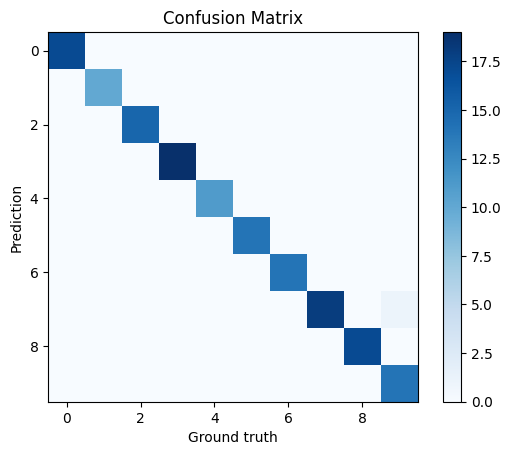

In [23]:
# Parameters to be tested in cross-validation
param_grid = {'C': [100, 500, 1000],
              'gamma': [0.005, 0.01, 0.1, 0.5, 1.0]}

# Support Vector Machine initialization
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=2)

# Training
t0 = time()
clf.fit(X_train, y_train)
print('Training completed in %0.3fs' % (time() - t0))

# Result of the cross-validation for parameter selection
print('Best parameters combination:')
print(' C: ' + str(clf.best_estimator_.C))
print(' gamma: ' + str(clf.best_estimator_.gamma))

# SVM test
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

# Confusion matrix
print('Confusion matrix:')
cm = confusion_matrix(y_test, y_pred)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel('Ground truth')
plt.ylabel('Prediction')
plt.title('Confusion Matrix')
plt.colorbar()
plt.show()

Despite the good performance, some warnings may appear due to the `n_fft` parameter, which specifies the number of points in the Fourier transform, defaulting to **2048**. If the input signal is shorter than this length, the Fourier transform may lead to padding or accuracy issues. Here are a few approaches to handle this:

1. **Set a Smaller Value for `n_fft`**  
   Use a value for `n_fft` that is a power of 2 and less than the length of the signal. For example:
   ```python
   mfccs = mfcc(y=sound_data * 1.0, sr=sound_rate, n_fft=1024)
   ```

2. **Apply Zero-Padding to the Signal**  
   Keep `n_fft = 2048`, but apply zero-padding to the signal if it is shorter than 2048. This approach keeps the default Fourier window size:
   ```python
   if len(sound_data) < 2048:
       sound_data = np.pad(sound_data, (0, 2048 - len(sound_data)))

   mfccs = mfcc(y=sound_data * 1.0, sr=sound_rate)
   ```

3. **Dynamic Adjustment of `n_fft`**  
   Use `2048` if the signal is long enough; otherwise, set `n_fft` to the length of the signal:
   ```python
   n_fft = min(2048, len(sound_data))
   mfccs = mfcc(y=sound_data * 1.0, sr=sound_rate, n_fft=n_fft)
   ```

The first two approaches maintain a fixed `n_fft` value for each observation, whereas the third approach allows `n_fft` to vary dynamically, depending on the signal length.

Now, proceed to implement each option individually by first defining the different feature extractors and then reproducing the following code:

```python
# Data loading
X_train, X_test, y_train, y_test = load_data(feature_extractor=feats_mfcc, normalize=True)

# Parameters to be tested in cross-validation
param_grid = {'C': [100, 500, 1000],
          'gamma': [0.005, 0.01, 0.1, 0.5, 1.0]}

# Support Vector Machine initialization
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=2)

# Training
t0 = time()
clf = clf.fit(X_train, y_train)
print('Training completed in %0.3fs' % (time() - t0))

# Result of the cross validation for parameters selection
print('Best parameters combination:')
print(' C: '+str(clf.best_estimator_.C))
print(' gamma: '+str(clf.best_estimator_.gamma))

# SVM test
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

# Confusion matrix
print('Confusion matrix:')
cm = confusion_matrix(y_test, y_pred)
plt.imshow(cm, cmap=plt.cm.Blues);
plt.xlabel('Ground truth');
plt.ylabel('Prediction');

```

**Note**: To enhance code readability, encapsulate all these steps within a single function.

In [24]:
def train_and_evaluate_svm(feature_extractor, normalize=True):
    # Data loading
    X_train, X_test, y_train, y_test = load_data(feature_extractor=feature_extractor, normalize=normalize)

    # Parameters to be tested in cross-validation
    param_grid = {'C': [100, 500, 1000],
                  'gamma': [0.005, 0.01, 0.1, 0.5, 1.0]}

    # Support Vector Machine initialization
    clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=2)

    # Training
    t0 = time()
    clf.fit(X_train, y_train)
    print('Training completed in %0.3fs' % (time() - t0))

    # Result of the cross-validation for parameter selection
    print('Best parameters combination:')
    print(' C: ' + str(clf.best_estimator_.C))
    print(' gamma: ' + str(clf.best_estimator_.gamma))

    # SVM test
    y_pred = clf.predict(X_test)
    print(classification_report(y_test, y_pred))

    # Confusion matrix
    print('Confusion matrix:')
    cm = confusion_matrix(y_test, y_pred)
    plt.imshow(cm, cmap=plt.cm.Blues)
    plt.xlabel('Ground truth')
    plt.ylabel('Prediction')
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.show()

### **5.1 MFCC Feature Extractor (attempt 1)**

Use a value for `n_fft` that is a power of 2 and less than the length of your signal. For example:
```python
mfccs = mfcc(y=sound_data * 1.0, sr=sound_rate, n_fft=1024)
```

In [25]:
def feats_mfcc1(input, rate=8000, tsize=10):
    # Step 1: Extract 2-dimensional feature through the function spectrogram
    input_matrix = mfcc(y=input*1.0, sr=rate, n_fft = 1024)

    # Step 2: Force the feature time (spec_times) to have a fixed size
    truncated_matrix = input_matrix[:, 0:min(input_matrix.shape[1], tsize)]
    if truncated_matrix.shape[1] < tsize:
      zero_padding = np.zeros((truncated_matrix.shape[0], tsize - truncated_matrix.shape[1]))
      output_matrix = np.concatenate((truncated_matrix, zero_padding), axis=1)
    else:
      output_matrix = truncated_matrix

    # Step 3: Unroll the 2-dimensional feature into a 1-dimensional vector
    output = output_matrix.ravel()

    return output

Training completed in 7.931s
Best parameters combination:
 C: 100
 gamma: 0.005
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        15
           3       0.95      1.00      0.97        19
           4       1.00      1.00      1.00        11
           5       1.00      1.00      1.00        14
           6       1.00      0.93      0.96        14
           7       1.00      0.95      0.97        19
           8       1.00      1.00      1.00        17
           9       0.93      1.00      0.97        14

    accuracy                           0.99       150
   macro avg       0.99      0.99      0.99       150
weighted avg       0.99      0.99      0.99       150

Confusion matrix:


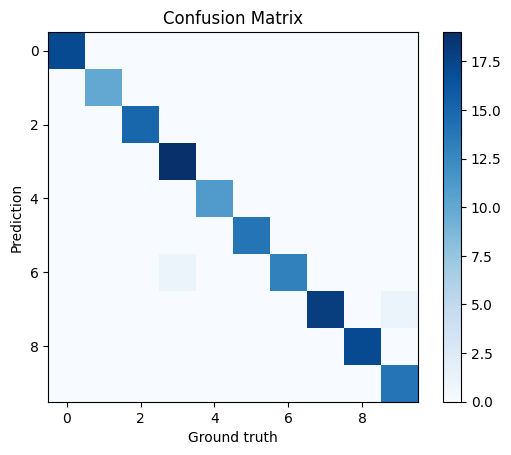

In [26]:
train_and_evaluate_svm(feats_mfcc1)

### **5.2 MFCC Feature Extractor (attempt 2)**

Keep `n_fft = 2048`, but apply zero-padding to the signal if it is shorter than 2048. This approach keeps the default Fourier window size:
   ```python
   if len(sound_data) < 2048:
       sound_data = np.pad(sound_data, (0, 2048 - len(sound_data)))

   mfccs = mfcc(y=sound_data * 1.0, sr=sound_rate)
   ```

In [27]:
def feats_mfcc2(input, rate=8000, tsize=10):
    # Step 1: Extract 2-dimensional feature through the function spectrogram
    if len(input) < 2048:
      input = np.pad(input, (0, 2048 - len(input)))

    input_matrix = mfcc(y=input*1.0, sr=rate)

    # Step 2: Force the feature time (spec_times) to have a fixed size
    truncated_matrix = input_matrix[:, 0:min(input_matrix.shape[1], tsize)]
    if truncated_matrix.shape[1] < tsize:
      zero_padding = np.zeros((truncated_matrix.shape[0], tsize - truncated_matrix.shape[1]))
      output_matrix = np.concatenate((truncated_matrix, zero_padding), axis=1)
    else:
      output_matrix = truncated_matrix

    # Step 3: Unroll the 2-dimensional feature into a 1-dimensional vector
    output = output_matrix.ravel()

    return output

Training completed in 7.432s
Best parameters combination:
 C: 100
 gamma: 0.005
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        15
           3       1.00      1.00      1.00        19
           4       1.00      1.00      1.00        11
           5       1.00      1.00      1.00        14
           6       1.00      1.00      1.00        14
           7       1.00      0.95      0.97        19
           8       1.00      1.00      1.00        17
           9       0.93      1.00      0.97        14

    accuracy                           0.99       150
   macro avg       0.99      0.99      0.99       150
weighted avg       0.99      0.99      0.99       150

Confusion matrix:


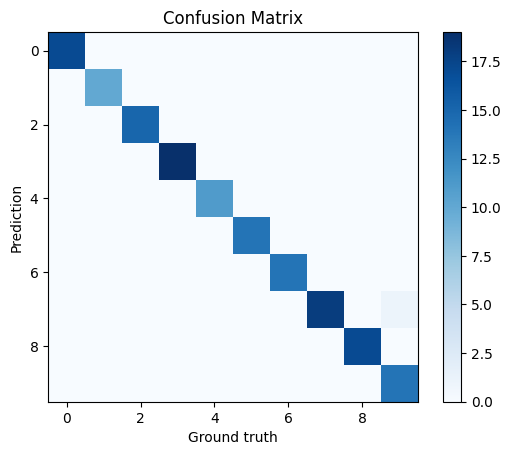

In [28]:
train_and_evaluate_svm(feats_mfcc2)

### **5.3 MFCC Feature Extractor (attempt 3)**

Use `2048` if the signal is long enough; otherwise, set `n_fft` to the length of the signal:
   ```python
   n_fft = min(2048, len(sound_data))
   mfccs = mfcc(y=sound_data * 1.0, sr=sound_rate, n_fft=n_fft)
   ```

In [29]:
def feats_mfcc3(input, rate=8000, tsize=10):
    # Step 1: Extract 2-dimensional feature through the function spectrogram
    input_matrix = mfcc(y=input*1.0, sr=rate, n_fft=min(2048, len(input)))

    # Step 2: Force the feature time (spec_times) to have a fixed size
    truncated_matrix = input_matrix[:, 0:min(input_matrix.shape[1], tsize)]
    if truncated_matrix.shape[1] < tsize:
      zero_padding = np.zeros((truncated_matrix.shape[0], tsize - truncated_matrix.shape[1]))
      output_matrix = np.concatenate((truncated_matrix, zero_padding), axis=1)
    else:
      output_matrix = truncated_matrix

    # Step 3: Unroll the 2-dimensional feature into a 1-dimensional vector
    output = output_matrix.ravel()

    return output

Training completed in 7.797s
Best parameters combination:
 C: 100
 gamma: 0.005
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        15
           3       1.00      1.00      1.00        19
           4       1.00      1.00      1.00        11
           5       1.00      1.00      1.00        14
           6       1.00      1.00      1.00        14
           7       1.00      0.95      0.97        19
           8       1.00      1.00      1.00        17
           9       0.93      1.00      0.97        14

    accuracy                           0.99       150
   macro avg       0.99      0.99      0.99       150
weighted avg       0.99      0.99      0.99       150

Confusion matrix:


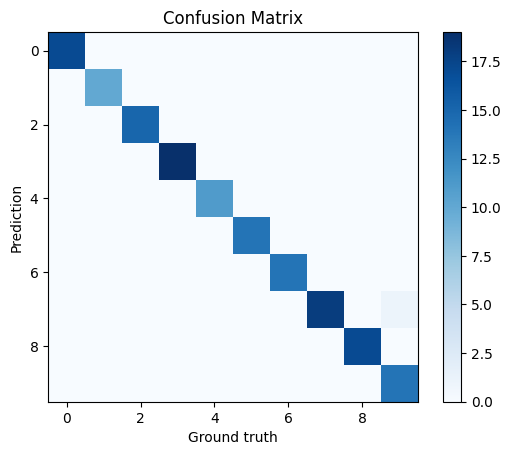

In [30]:
train_and_evaluate_svm(feats_mfcc3)

Each of the three attempts reflects the same high performance as the original feature extractor without any specific adjustments to `n_fft`, with all previous warnings resolved. This suggests that setting a fixed length for each audio signal or varying it based on its original length has neutral impact on performance.

The model’s performance on this test set is exceptional, with an accuracy of 99%. Precision and recall are nearly perfect across all classes, reaching 100% in most cases, and exceeding 90% for the few exceptions. These consistently strong results indicate robust classification.

This high performance demonstrates that using `mfcc` as a feature extractor is more effective for this classification task compared to using a `standard spectrogram`. This advantage may suggest that, in this particular application, `mfcc` has the ability to reduce noise and create more comparable training and test sets.

It’s worth noting that MFCCs are designed to reflect the human ear’s perception of sound, emphasizing frequencies that are more distinguishable to humans. By mapping frequencies to the mel scale—a nonlinear scale aligned with our perception of pitch changes—MFCCs capture audio features more relevant to human speech and other complex sounds.